In [23]:
import cv2
import numpy as np
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe' # Your path to tesseract.exe in Program Files
# download from here https://github.com/UB-Mannheim/tesseract/wiki
# pip install pytesseract
# set path as above
# https://stackoverflow.com/questions/50951955/pytesseract-tesseractnotfound-error-tesseract-is-not-installed-or-its-not-i
import pytesseract
from matplotlib import pyplot as plt


In [ ]:
# CHANGE THE IMAGE!!! IT HAS BAD QUALITY

In [33]:
# Define our imshow function
def imshow(title = "Image", image = None, size = 5):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

In [52]:
# Read the image
image = cv2.imread('rotated_document.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [65]:
### RESIZE IMAGE!!!!!

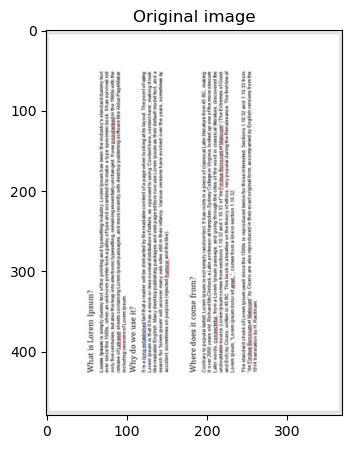

Height: 480, Width: 369


In [53]:
imshow('Original image', image)
h = image.shape[0]
w = image.shape[1]
print(f'Height: {h}, Width: {w}')

In [54]:
# Use a text detection algorithm or OCR to get bounding boxes
# For example, using Tesseract OCR
custom_config = r'--oem 3 --psm 6'
boxes = pytesseract.image_to_boxes(gray, config=custom_config).splitlines()

<b> Polar Coordinates </b>

In polar coordinates, a point in the plane is determined by its distance r from the origin and the angle theta (in radians) between the line from the origin to the point and the x-axis (see the figure below).

![Polar_coordinates.png](Polar_coordinates.png)

https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html  
https://sites.science.oregonstate.edu/math/home/programs/undergrad/CalculusQuestStudyGuides/vcalc/coord/coord.html

In [55]:
# Extract coordinates of the bounding boxes
box_coordinates = [list(map(int, box.split()[1:5])) for box in boxes]

# Convert the coordinates to NumPy array for easier manipulation
box_coordinates = np.array(box_coordinates)

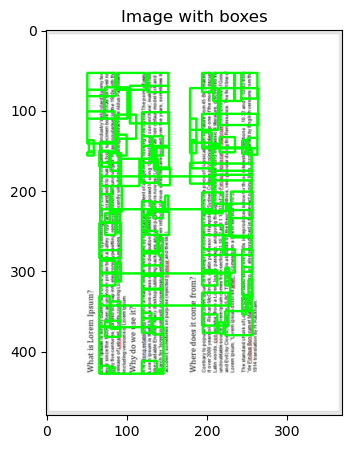

In [70]:
image_copy = image.copy()
# Draw bounding boxes on the image
for coordinates in box_coordinates:
    x, y, w, h = coordinates
    cv2.rectangle(image_copy, (x, y), (w, h), (0, 255, 0), 2)

imshow('Image with boxes', image_copy)

In [66]:
# TOOO CHEEEECK !!!!!!!!!
# https://stackoverflow.com/questions/23783061/detect-text-orientation

In [71]:
# Apply Hough Line Transform to detect lines in the image
lines = cv2.HoughLines(gray, 1, np.pi / 180, 100)

In [72]:
# Calculate the average angle of the detected lines
# This loop iterates over each line detected by the Hough Line Transform. lines is a list of lines where each line is represented by a pair of values (rho, theta)
angles = []
for line in lines:
    rho, theta = line[0]
    angles.append(np.degrees(theta))

In [73]:
average_angle = np.mean(angles)

# Print the detected text orientation
print(f"Text Orientation: {average_angle} degrees")

Text Orientation: 81.56486511230469 degrees


In [64]:
# Extract coordinates of the bounding boxes
box_coordinates = [list(map(int, box.split()[1:5])) for box in boxes]

# Draw bounding boxes on the image
for coordinates in box_coordinates:
    x, y, w, h = coordinates
    cv2.rectangle(image, (x, y), (w, h), (0, 255, 0), 2)

# Display the result
cv2.imshow('Text Detection', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [63]:
image_copy = image.copy()
for line in lines[:4]:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = int(a * rho)
    y0 = int(b * rho)
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(image_copy, (x1, y1), (x2, y2), (0, 0, 255), 1)

# Display the result
cv2.imshow('Text Orientation Detection', image_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [46]:
# Calculate the rotation matrix
rotation_matrix = cv2.getRotationMatrix2D((w / 2, h / 2), -average_angle, 1)

# Apply the rotation to the image
rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR)

# Display the original and rotated images
cv2.imshow('Original Image', image)
cv2.imshow('Rotated Image', rotated_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
cv2.imshow(image)

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
